# Exploratory Data Analysis
We'll start by importing packages, reading the data into a dataframe, and checking the datatypes and for nulls. Convenience functions have been written separately so as not to clog up the notebook unnecessarily; see `utils.py` for details.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from datetime import datetime
import utils


# FONT_SIZE_TICKS = 15
# FONT_SIZE_TITLE = 20
# FONT_SIZE_AXES = 17

# colors = {'white': '#fdfdfd',
#           'dark blue': '#06072c',
#           'chalk blue': '#5f85a6',
#           'light gray': '#cfd1d4',
#           'blue gray': '#a3aab5',
#           'black': '#000000'}

# COLORS = [v for v in colors.values()]

# sns.set_palette(sns.color_palette(COLORS))


In [2]:
raw = pd.read_csv('data/raw.csv')
raw.head()

,Location,Date,Time,Latitude,Longitude,Altitude,YRMODAHRMI,Month,Hour,Season,Humidity,AmbientTemp,PolyPwr,Wind.Speed,Visibility,Pressure,Cloud.Ceiling
0,Camp Murray,20171203,1145,47.11,-122.57,84,2.017120e+11,12,11,Winter,81.71997,12.86919,2.42769,5,10.0,1010.6,722
1,Camp Murray,20171203,1315,47.11,-122.57,84,2.017120e+11,12,13,Winter,96.64917,9.66415,2.46273,0,10.0,1011.3,23
2,Camp Murray,20171203,1330,47.11,-122.57,84,2.017120e+11,12,13,Winter,93.61572,15.44983,4.46836,5,10.0,1011.6,32
3,Camp Murray,20171204,1230,47.11,-122.57,84,2.017120e+11,12,12,Winter,77.21558,10.36659,1.65364,5,2.0,1024.4,6
4,Camp Murray,20171204,1415,47.11,-122.57,84,2.017120e+11,12,14,Winter,54.80347,16.85471,6.57939,3,3.0,1023.7,9


The following line tidies the various time-related columns and inserts a datatime column for time-series visualisation later on. 

In [3]:
raw = utils.fix_dates(raw)
raw.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21045 entries, 0 to 21044
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Datetime       21045 non-null  datetime64[ns]
 1   Location       21045 non-null  object        
 2   Latitude       21045 non-null  float64       
 3   Longitude      21045 non-null  float64       
 4   Altitude       21045 non-null  int64         
 5   Season         21045 non-null  object        
 6   Humidity       21045 non-null  float64       
 7   AmbientTemp    21045 non-null  float64       
 8   Wind.Speed     21045 non-null  int64         
 9   Visibility     21045 non-null  float64       
 10  Pressure       21045 non-null  float64       
 11  Cloud.Ceiling  21045 non-null  int64         
 12  PolyPwr        21045 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(3), object(2)
memory usage: 2.1+ MB


From above, there are no nulls. However, the data is collected over 499 days from 23 May 2017 to 4 Oct 2018 in 15-minute intervals between 10:00 and 15.45. Assuming an ideal situation of a reading every 15 minutes over this period, we have a ceiling of 6 * 4 * 499 = 11976 possible readings per location and can compare the actual counts with this, as shown below. It's clear that the data collected is quite patchy, with a maximum of 23% of data points present in Travis, which would have to be addressed if we go ahead with time-series modelling later on.

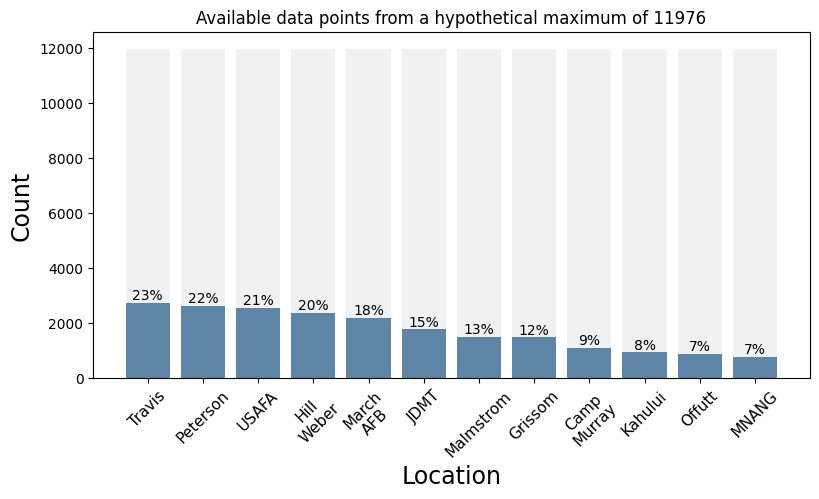

In [4]:
utils.visualise_missing_data(raw)

### Discrepancy between descriptive statistics here and in the paper
Calculating descriptive statistics for the numerical columns, it's noted that the values here differ from those in the paper for some of the features (see `variable units.png`). After investigating, the differences were due to approximately constant scaling factors for each feature, indicating some change of units had taken place. The function `fix_units()` calculates these and transforms the features accordingly. The second set of statistics is then left closely matching those in the paper.

In [5]:
numerical_features = [f for f in raw.columns if f not in ['Datetime', 'Season', 'Latitude', 'Longitude', 'Location']]

raw[numerical_features].describe().round(3).loc[['min', '25%', '50%', 'mean', '75%', 'max']].T

,min,25%,50%,mean,75%,max
Altitude,1.000,2.000,458.000,798.844,1370.000,1947.000
Humidity,0.000,17.529,33.124,37.122,52.594,99.988
AmbientTemp,-19.982,21.915,30.289,29.285,37.475,65.738
Wind.Speed,0.000,6.000,9.000,10.318,14.000,49.000
Visibility,0.000,10.000,10.000,9.700,10.000,10.000
Pressure,781.700,845.500,961.100,925.945,1008.900,1029.500
Cloud.Ceiling,0.000,140.000,722.000,515.967,722.000,722.000
PolyPwr,0.257,6.405,13.799,12.979,18.864,34.285


In [6]:
raw_clean = utils.fix_units(raw)

raw_clean[numerical_features].describe().round(3).loc[['min', '25%', '50%', 'mean', '75%', 'max']].T

,min,25%,50%,mean,75%,max
Altitude,0.303,0.607,138.932,242.325,415.582,590.612
Humidity,0.000,17.529,33.124,37.122,52.594,99.988
AmbientTemp,-19.982,21.915,30.289,29.285,37.475,65.738
Wind.Speed,0.000,9.665,14.497,16.621,22.551,78.929
Visibility,0.000,16.096,16.096,15.614,16.096,16.096
Pressure,781.700,845.500,961.100,925.945,1008.900,1029.500
Cloud.Ceiling,0.000,4.272,22.029,15.743,22.029,22.029
PolyPwr,0.257,6.405,13.799,12.979,18.864,34.285


With that done, we can rename the column headings and include the appropriate units.

In [7]:
raw_clean.columns = ['Datetime', 'Location', 'Latitude (deg)', 'Longitude (deg)', 'Altitude (m)', 'Season',
       'Humidity (%)', 'AmbientTemp (deg C)', 'WindSpeed (km/h)', 'Visibility (km)', 'Pressure (mbar)',
       'CloudCeiling (km)', 'Power (W)']

numerical_features = [f for f in raw_clean.columns if f not in ['Datetime', 'Season', 'Latitude (deg)', 'Longitude (deg)', 'Altitude (m)', 'Location']]

The following plots can be used to compare the distributions of various numerical features at each location, individually or side-by-side. We see that the power output, the target variable, often exhibits approximately bimodal distributions with the locations of the central peaks varying from site to site and with peak frequency occurring at high power in some cases (e.g. USAFA) and low power in others (e.g. Malmstrom). It can be seen from the violin/box plots that all features vary substantially with location. 

In [8]:
utils.compare_box_violins(raw_clean, numerical_features)

interactive(children=(Dropdown(description='Feature', index=6, options=('Humidity (%)', 'AmbientTemp (deg C)',…

In [9]:
utils.compare_histograms(raw_clean, numerical_features, bins=64)

interactive(children=(Dropdown(description='Location 1', index=10, options=('Camp Murray', 'Grissom', 'Hill We…

In [10]:
utils.scatterplot(raw_clean, numerical_features)

interactive(children=(Dropdown(description='Location', index=11, options=('Camp Murray', 'Grissom', 'Hill Webe…

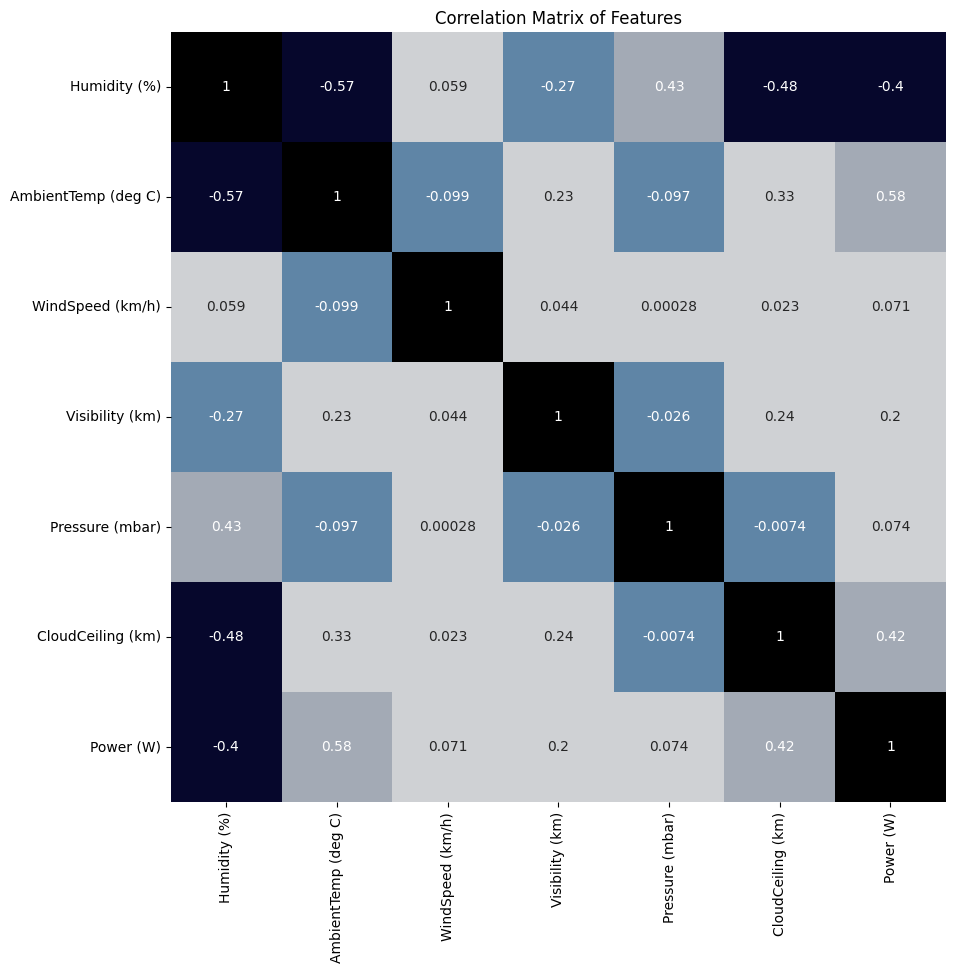

In [11]:
utils.correlation_matrix(raw_clean[numerical_features])

In [12]:
utils.plot_time_series(raw_clean, numerical_features)

interactive(children=(Dropdown(description='Location', index=11, options=('Camp Murray', 'Grissom', 'Hill Webe…

In [13]:
data = raw_clean.copy()
utils.create_map(data, time_increment='hour_of_day')


/Users/douglaslazenby/Documents/Projects/solar-forecasting/utils.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped_means[index[0]][index[1]] = row[0]
/Users/douglaslazenby/Documents/Projects/solar-forecasting/utils.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped_stds[index[0]][index[1]] = row[1]


<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import widgets, interact
import folium 
from collections import defaultdict
import base64

from typing import List

FONT_SIZE_TICKS = 15
FONT_SIZE_TITLE = 20
FONT_SIZE_AXES = 17

colors = {'white': '#fdfdfd',
          'dark blue': '#06072c',
          'chalk blue': '#5f85a6',
          'light gray': '#cfd1d4',
          'blue gray': '#a3aab5',
          'black': '#000000'}

COLORS = [v for v in colors.values()]

sns.set_palette(sns.color_palette(COLORS))

def fix_dates(data: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    if 'Datetime' in data.columns:
        return data
    
    data['Datetime'] = data.apply(
        lambda x: datetime.strptime(f"{x['Date']} {x['Time']}", "%Y%m%d %H%M"), axis=1)
    
    data.drop(['Date', 'Time', 'Month', 'Hour', 'YRMODAHRMI'], axis='columns', inplace=True)
    
    data = data[["Datetime"] + [col for col in list(data.columns) if col not in ["Datetime", 'PolyPwr']] + ['PolyPwr']]
    
    return data

def fix_units(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    data = df.copy()
    features = ['Altitude', 'Wind.Speed', 'Visibility', 'Cloud.Ceiling']
    converted = data[features].describe().round(3).loc[['min', '25%', '50%', 'mean', '75%', 'max']].reset_index(drop=True).copy()
    
    # From paper. Each column in from_paper contains the agregate statistics in the order above
    from_paper = pd.DataFrame([[0.3, 0.6, 140, 244, 417, 593], 
                  [0, 9.7, 14.5, 16.6, 22.5, 78.9], 
                  [0, 16.1, 16.1, 15.6, 16.1, 16.1],
                  [0, 4.3, 22, 15.7, 22, 22]]).T
    
    # Calculate conversion factor and modify feature accordingly
    for idx, feature in enumerate(features):
        cf = np.mean(from_paper.iloc[:, idx] / converted.iloc[:, idx])
        data[feature] = data[feature] * cf
        
    return data


def visualise_missing_data(df: pd.core.frame.DataFrame) -> None:
    """
    Stacked bar chart to visualise missing data. total_possible_points is a hypothetical maximum of 
    readings that could be taken at each location from over the date range of df (see EDA notebook for details).
    
    Args:
        df: The dataset.
    """
    # Get df of counts and labels for plot
    total_possible_points = 11976

    missing_df = df.copy().groupby('Location').count()['Datetime'].sort_values(ascending=False).to_frame().reset_index()
    missing_df.rename(columns={'Datetime': 'num_readings'}, inplace=True)

    missing_df['prop_missing'] = (missing_df['num_readings'] / total_possible_points).round(2)

    locations = missing_df['Location'].values
    num_readings = missing_df['num_readings'].values
    missing_readings = (total_possible_points - missing_df['num_readings']).values
    percentage_labels = [f"{int(v*100)}%" for v in missing_df['prop_missing'].values]
    
    # Plot bar chart
    plt.figure(figsize=(8,4))

    bars1 = plt.bar(locations, num_readings, color=COLORS[2])
    bars2 = plt.bar(locations, missing_readings, bottom=num_readings, color=COLORS[3], alpha=0.3)

    plt.tight_layout()

    for b1, b2, l in zip(bars1, bars2, percentage_labels):
        plt.text(b1.get_x() + b2.get_width() / 2, b1.get_height() + 0.5, l,
                ha='center', va='bottom', color='black', fontsize=10)

    plt.xlabel('Location', fontsize=FONT_SIZE_AXES)
    plt.ylabel('Count', fontsize=FONT_SIZE_AXES)
    plt.title('Available data points from a hypothetical maximum of 11976')

    plt.xticks(range(len(locations)), labels=[l.replace(' ', '\n') for l in locations], fontsize=11, rotation=45)

    plt.show()
    

def add_day_month(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    if 'month_of_year' in df.columns:
        return df
    data = df.copy()
    data['month_of_year'] = pd.DatetimeIndex(data['Datetime']).month
    data['hour_of_day'] = pd.DatetimeIndex(data['Datetime']).hour
    data.loc[data['hour_of_day'] == 0, 'hour_of_day'] = 24
    data = data[[f for f in data.columns if f != 'Power (W)'] + ['Power (W)']]
    return data

def create_map(df: pd.core.frame.DataFrame, time_increment: str = 'month_of_year') -> folium.Map:
    """
    Interactive map displaying geolocations of PV arrays. Includes popups of average (hourly or monthly)
    power output of a given cell.
    
    Args:
        df: The dataset.
        time_increment (optional): how to average the power output. Can be 'month_of_year' or 'hour_of_day'. 
    """
    MONTHS = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
              7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

    power = 'Power (W)'
    if 'month_of_year' not in df.columns:
        df = add_day_month(df)
    data = df[['Latitude (deg)', 'Longitude (deg)', power, 'Location', time_increment]].copy()
    data_grouped = data.groupby(['Location', time_increment]).agg(({power: ['mean', 'std']}))
    ymin = data_grouped[power]['mean'].min()
    ymax = data_grouped[power]['mean'].max()

    grouped_means = defaultdict(dict)
    grouped_stds = defaultdict(dict)

    for index, row in data_grouped.iterrows():
        grouped_means[index[0]][index[1]] = row[0]
        grouped_stds[index[0]][index[1]] = row[1]

    for key in grouped_means:
        if (time_increment == 'month_of_year'):
            keys = list(grouped_means[key].keys())
            label = 'Monthly average'
        else:
            keys = list(grouped_means[key].keys())
            label = 'Hourly average'

        values, stds = [], []
        for subkey in keys:
            values.append(grouped_means[key][subkey])
            stds.append(grouped_stds[key][subkey])
        
        values = np.array(values)
        stds = np.array(stds)
        
        plt.plot(keys, values, '-o', label=label, color=COLORS[2])
        plt.fill_between(keys, values - stds, values + stds, alpha=0.2, color=COLORS[3])
        plt.ylim(ymin, ymax)
        plt.title(f'Location {key} avg. {power} / {time_increment.split("_")[0]}')
        plt.ylabel(f'Avg. {power}')
        plt.xlabel(time_increment[0].upper() + time_increment[1:].replace('_', ' '))
        plt.legend(loc="upper left")
        if (time_increment == 'month_of_year'):
            plt.xticks(keys, labels=[MONTHS[k] for k in keys], fontsize=11)
        plt.savefig(f'img/tmp/{key}.png', dpi=50)

        plt.clf()

    data_grouped_grid = data.groupby('Location').agg(({power: 'mean', 'Latitude (deg)': 'min', 'Longitude (deg)': 'min'}))
    
    data_grouped_grid_array = np.array(
        [
            data_grouped_grid['Latitude (deg)'].values,
            data_grouped_grid['Longitude (deg)'].values,
            data_grouped_grid[power].values,
            data_grouped_grid.index.values
        ]
    ).T

    m = folium.Map(
        location=[37.519934, -114.6],
        tiles='openstreetmap',
        zoom_start=3.5,
        width=1200,
        height=800
    )

    width, height = 300, 300
    fg = folium.FeatureGroup(name="My Map")
    for lat, lng, _, location in data_grouped_grid_array:
        enc = base64.b64encode(open(f"img/tmp/{location}.png", 'rb').read())
        html = "<img src='data:image/png;base64,{}'>".format
        iframe = folium.IFrame(html(enc.decode('UTF-8', errors='ignore')), width=width+10, height=height+10)
        popup = folium.Popup(iframe, max_width=300, max_height=250)
        fg.add_child(folium.CircleMarker(location=[lat, lng], radius = 15, popup=popup,
        fill_color=COLORS[1], color='', fill_opacity=0.5))
        m.add_child(fg)
        
    return m